In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
rare_AD = pd.read_csv('../Data/data_gc_homo_poly_unique_1319.csv')

In [3]:
pheno = pd.read_csv('../Data/phenotypes_1319.csv',sep=';')

In [4]:
pheno.rename(columns={'diabetes (1=affected, 0=not affected, N/A= data not available)':'Diabetes',
                     'hypertension (1=affected, 0=not affected, N/A= data not available)':'Hypertension',
                     'cancer  (1=affected, 0=not affected, N/A= data not available)':'Cancer',
                     'Autoimmune disease (1 = Yes, 0 = No)':'Autoimmune disease',
                     'Congestive/Ischemic Heart Failure (1= Yes; 0=No)':'Congestive/Ischemic Heart Failure',
                     'Obesity (1= Yes; 0=No)':'Obesity',
                     'Dyslipidemia (1= Yes; 0=No)':'Dyslipidemia',
                     'Hypothyroidism (1= Yes; 0=No)':'Hypothyroidism',
                     'Asthma/COPD/OSAS (1= Yes; 0=No)':'Asthma/COPD/OSAS'}, inplace=True)

Scarto gli artefatti

In [5]:
rare_AD.drop(columns=['ARSD_0', 'ARSD_1', 'ARSD_2', 'VCX_1','VCX2_1'], inplace=True, axis=1)
len(rare_AD.columns)

12947

Scarto le mutazioni che terminano con `_0`

In [6]:
#todrop = rare_AD.columns[rare_AD.columns.str.contains('_0')].tolist()
#rare_AD.drop(columns=todrop, inplace=True)
#len(rare_AD.columns)

In [7]:
12947-7607

5340

Rimuovo i geni del cromosoma X

In [8]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), rare_AD.columns.tolist())
genes_X = chr_X['genes_x'].tolist()

In [9]:
selected = []
for x in rare_AD.columns:
    gene = x.split('_')[0]
    if gene in chr_X['genes_x'].tolist():
        selected.append(x)

In [10]:
rare_AD.drop(columns=selected, inplace=True)
len(rare_AD.columns)

12697

Filtro per etnia

In [11]:
#pheno['Ethnicity'] = pheno['Ethnicity (white=1, black=2, asian=3, hispanic=4)']
#pheno = pheno[(pheno['Ethnicity']=='1') | (pheno['Ethnicity'].isna())]

Mantengo solo pazienti con un grading

In [12]:
pheno = pheno[pheno['grading_1319_adj_a_s'].notna()]

Scarto pazienti senza età

In [13]:
pheno = pheno[pheno['Age'].notna()]

Cambio l'indice dei pazienti

In [14]:
pheno.rename(columns={"UsedSampleCode":"key"}, inplace=True)
pheno.set_index('key',inplace=True)

Scarto pazienti non corrispondenti

In [15]:
rare_AD.rename(columns={"Unnamed: 0": "key"}, inplace=True)
rare_AD.set_index('key',inplace=True)

rare_AD = rare_AD[rare_AD.index != 'COV2925-1241_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2928-1242_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3204-1334_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3196-1326_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2735-1159_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3211-1341_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2233-939_hg38']

rare_AD.index = rare_AD.index.str.replace('_hg38','')

In [16]:
grading = pheno[['grading_1319_adj_a_s','Diabetes', 'Hypertension',
                 'Cancer', 'Autoimmune disease','Congestive/Ischemic Heart Failure', 
                 'Asthma/COPD/OSAS',
       'Hypothyroidism', 'Obesity', 'Dyslipidemia','Gender (M=0, F=1)']]

df = rare_AD.join(grading, on='key')
df.rename(columns={'grading_1319_adj_a_s':'grading'}, inplace=True)

df

,AADACL3_0,ABCA4_0,ABCA4_1,ABL2_0,ACBD3_1,ACKR1_0,ACKR1_1,ACTL8_1,ACTN2_1,ACTRT2_0,...,Diabetes,Hypertension,Cancer,Autoimmune disease,Congestive/Ischemic Heart Failure,Asthma/COPD/OSAS,Hypothyroidism,Obesity,Dyslipidemia,"Gender (M=0, F=1)"
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-10,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-11,0,0,0,0,0,0,1,1,1,0,...,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0
AR-COV-12,0,0,1,0,1,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-13,0,0,0,0,0,0,1,1,1,0,...,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-14,0,0,0,0,1,0,0,0,1,0,...,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VE101,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
VE10,0,0,0,1,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
VE97,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0


Mantengo solo le femmine

In [17]:
df = df[df['Gender (M=0, F=1)']==0].iloc[:,:-1]

df = df[df['grading']!='none']
df.dropna(inplace=True)

In [18]:
#df.drop(columns=value_counts[value_counts['percentage of 1'] > 90].mutation, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df.reset_index(inplace=True)

In [19]:
df.drop(columns='key',inplace=True)

In [20]:
df

,AADACL3_0,ABCA4_0,ABCA4_1,ABL2_0,ACBD3_1,ACKR1_0,ACKR1_1,ACTL8_1,ACTN2_1,ACTRT2_0,...,grading,Diabetes,Hypertension,Cancer,Autoimmune disease,Congestive/Ischemic Heart Failure,Asthma/COPD/OSAS,Hypothyroidism,Obesity,Dyslipidemia
0,0,0,0,0,0,0,0,0,1,0,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,1,1,1,0,...,0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0,0,1,0,...,1,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,1,0,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0,0,0,0,0,0,0,0,1,0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
378,0,0,0,0,1,0,0,0,1,0,...,0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0
379,0,0,0,0,0,0,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
380,0,0,0,1,0,0,0,0,1,0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


Scarto le mutazioni non informative

In [22]:
value_counts = df.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row[1]/(len(df)), axis=1)

In [23]:
df.drop(columns=value_counts[value_counts[value_counts.columns[1]] >= len(df)].mutation, inplace=True)
df.drop(columns=value_counts[value_counts[value_counts.columns[2]] >= len(df)].mutation, inplace=True)

# Optimizing Lasso Classification 

In [24]:
target_variable = 'grading'
input_variables = df.columns[df.columns!=target_variable]

X = df[input_variables]
X.columns.values[:-9] += '_homo'
y = df[target_variable]
X_nic = pd.read_csv('../Data/Male/X_GC_homo_male_antonio.csv', sep=';')
X_nic.drop(columns='Unnamed: 0', inplace=True)
y_nic = pd.read_csv('../Data/Male/y_GC_homo_male_antonio.csv', sep=';')['0']

In [25]:
len(X_nic.columns.tolist())

12376

In [26]:
len(X_nic.columns.tolist()) - len(X.columns.tolist())

98

In [27]:
np.setdiff1d(X_nic.columns.tolist(), X.columns.tolist())

array(['ABCC4_0_homo', 'ABCG2_0_homo', 'ADRB3_0_homo', 'AKR1A1_0_homo',
       'ANP32D_0_homo', 'ARHGEF18_0_homo', 'ARMC9_1_homo',
       'ATP1A4_0_homo', 'ATP9B_0_homo', 'B3GAT3_0_homo',
       'BCL2L2;BCL2L2-PABPN1_1_homo', 'BDKRB2_0_homo', 'BEAN1_0_homo',
       'BMP3_0_homo', 'BMP3_1_homo', 'BOLA1_0_homo', 'BORCS5_0_homo',
       'C6orf118_0_homo', 'CALHM4_0_homo', 'CD1A_0_homo', 'CDRT15_0_homo',
       'CGAS_0_homo', 'CLSTN3_0_homo', 'COX10_0_homo', 'CWH43_0_homo',
       'DEF8_0_homo', 'DNAJC30_0_homo', 'EEF2KMT_0_homo', 'FBXO30_0_homo',
       'FER_0_homo', 'FHL5_0_homo', 'GABPB2_0_homo', 'GAMT_0_homo',
       'GATC_0_homo', 'GFI1_0_homo', 'GOLGA5_0_homo',
       'GTF2A1L;STON1-GTF2A1L_0_homo', 'HACD3_0_homo', 'HEATR5B_0_homo',
       'HIST1H1B_0_homo', 'ICK_0_homo', 'IL37_0_homo', 'KAT6A_0_homo',
       'KLRD1_1_homo', 'KNCN_0_homo', 'LCT_0_homo', 'LIPM_0_homo',
       'MACC1_0_homo', 'MARCO_0_homo', 'MEOX1_0_homo', 'MFSD4A_0_homo',
       'MIA3_0_homo', 'MIB2_0_homo', 'MST1R_0

In [28]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  0  53.7%
Class  1  46.3%



In [29]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [30]:
c = np.logspace(np.log10(1e-2), np.log10(1e3), 51)

In [31]:
lasso = LogisticRegression(random_state=1234, solver="liblinear",penalty='l1',verbose=1)
parameters = {'C':c}
lasso_gs = GridSearchCV(lasso, parameters, n_jobs=-1, cv=crossvalidation, scoring='roc_auc')
lasso_gs.fit(X_train,y_train)

[LibLinear]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=1234,
                                          solver='liblinear', verbose=1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1...
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [32]:
s = {'score':lasso_gs.cv_results_['mean_test_score'],'std':lasso_gs.cv_results_['std_test_score'],'c':1/c}
scores = pd.DataFrame(data=s)

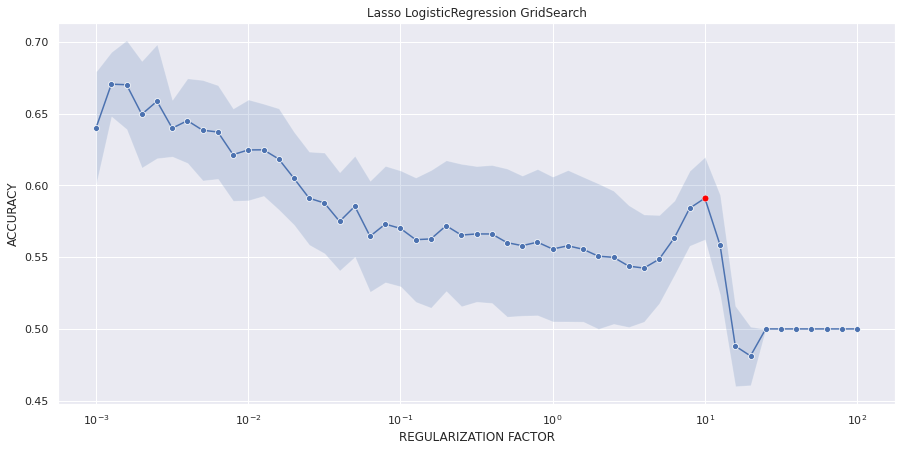

In [82]:
sns.set_theme()
plt.figure(figsize=(15,7))
ax = sns.lineplot(data=scores, x='c', y='score', ci=scores.std, markers=True, marker='o')
ax.fill_between(1/parameters['C'], y1=lasso_gs.cv_results_['mean_test_score'] - lasso_gs.cv_results_['std_test_score']/2, 
                y2=lasso_gs.cv_results_['mean_test_score'] + lasso_gs.cv_results_['std_test_score']/2, alpha=.2)
ax.set_xscale('log')
ax.set_ylabel('ACCURACY')
ax.set_xlabel('REGULARIZATION FACTOR')
ax.set_title('Lasso LogisticRegression GridSearch')
plt.plot(1/c[10],s['score'][10], 'ok', markersize=5, color='red')
#ax.set_ylim([0.475,0.7])

In [83]:
lasso_gs.best_estimator_

LogisticRegression(C=794.3282347242822, penalty='l1', random_state=1234,
                   solver='liblinear', verbose=1)

In [90]:
method_name = 'Lasso'

#lasso = lasso_gs.best_estimator_
lasso = LogisticRegression(C=c[10], penalty='l1', random_state=5, solver='liblinear', verbose=1)

xval_score = cross_val_score(lasso,X_train,y_train,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

lasso.fit(X_train,y_train)
yp = lasso.predict(X_test)

importances = lasso.coef_

prec = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\tAccuracy (Test) %.3f"%accuracy_score(y_test, yp))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC (CV)  %.3f"%auc_metric)
print("\t      AUC (Test)%.3f"%roc_auc_score(y_test, yp))
print("\n")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

                                   Lasso
	  Accuracy (CV) 0.581 0.060
	Accuracy (Test) 0.615
	      Precision 0.569
	      Recall    0.433
	      F1        0.486
	      AUC (CV)  0.592
	      AUC (Test)0.537




In [91]:
importances = lasso.coef_.flatten()
importances.shape[0]

12278

In [92]:
indices = np.argsort(np.absolute(importances))[::-1]#[0:100]
indices = indices[np.absolute(importances[indices])>0.000001]

In [93]:
selected_features = importances[indices]

In [94]:
len(selected_features)

42

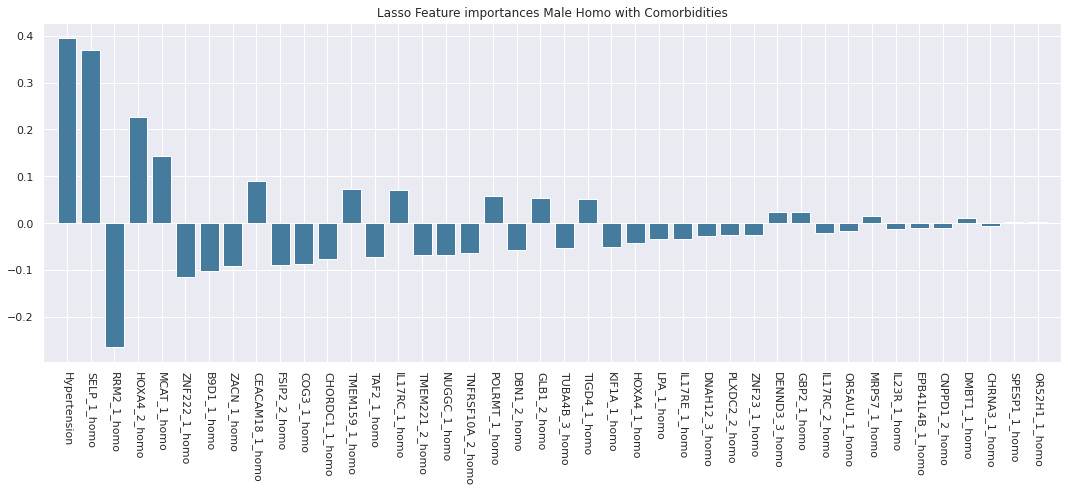

In [66]:
n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

plt.title("Lasso Feature importances Male Homo with Comorbidities")

ax.bar(range(n_features), importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X.columns[indices],rotation='-90')
#ax.get_xticklabels()[1].set_fontweight("bold")
#ax.get_xticklabels()[4].set_fontweight("bold")
#ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, len(selected_features)])#X.shape[1]])
plt.tight_layout()
#plt.savefig('./Plots/Feature_importances_adjbyage.png',dpi=150)
plt.show()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

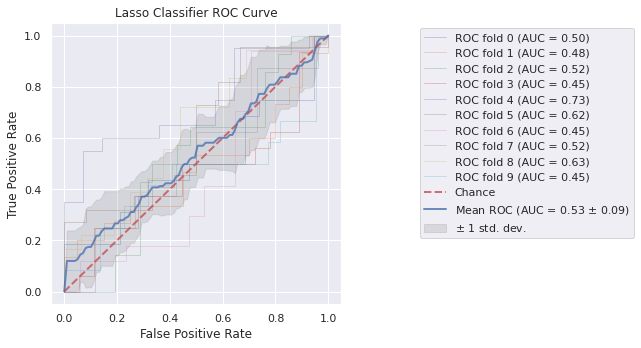

In [60]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,5))
for i, (train, test) in enumerate(crossvalidation.split(X_train, y_train)):
    lasso.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(lasso, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Lasso Classifier ROC Curve")
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
#plt.savefig('./Plots/Lasso Adjusted by age ROC.png',dpi=150)
plt.show()

In [63]:
yp_cv = cross_val_predict(lasso, X_train, y_train, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y_train, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Text(0.5, 1.0, 'Lasso Confusion Matrix')

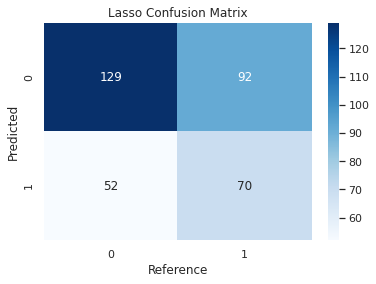

In [64]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Lasso Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])
#plt.savefig('./Plots/Lasso Confusion matrix adj by age.png', dpi=150)

In [65]:
#selected_features = X.columns[indices]

In [ ]:
#df_out = df.loc[:, selected_features]
#df_out['grading'] = df['grading']
#df_out.to_csv('./selected_features_adjusted_by_age.csv',index=False)